# Изучение закономерностей, определяющих успешность игр

**Задача проекта:** используя исторические данные о продажах компьютерных игр, оценки пользователей и экспертов, жанры и платформы, выявить закономерности, определяющие успешность игры.

## Общая информация о датасете

Импортируем необходимые библиотеки, открываем файл, изучаем общую информацию о имеющемся датасете.

In [1]:
# в данную ячейку будем добавлять библиотеки по мере их необходимости
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
try:
    data = pd.read_csv('C:/Users/Student/Desktop/games.csv')
except:
    data = pd.read_csv('https://drive.google.com/drive/datasets/games.csv')

In [3]:
data.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


## Подготовка данных

Приведем названия столбцов к нижнему регистру для удобства их дальнейшего использования.

In [5]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Преобразование данных в нужные типы и обработка пропусков

Еще раз посмотрим какие типы данных в каких столбцах имеются.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Причинами пропусков в данных могла стать техническая ошибка при выгрузке или человеческий фактор. Посмотрим, что можно сделать в каждом конкретном случае.

Для преобразования года релиза в целое число сперва удалим строки с пропущенными значениями, проверив какой процент данных мы потеряем.

In [7]:
#поделим сумму нулевых значений столбца "год релиза" на общее число строк в датафрейме
print(f"{data['year_of_release'].isna().sum() / data['platform'].count():.2%}") 

1.61%


Считаем такой процент незначительным, тем более, что отсутствие года релиза в данных помешает нам определить актуальность информации по данным строкам для нашего исследования.

In [8]:
#удалим строки с нулевыми значениями в столбце "год релиза" из датасета
data = data.dropna(subset = ['year_of_release']) 
data = data.reset_index(drop=True) #обновим индексы
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [9]:
data['year_of_release'] = data['year_of_release'].astype(int) #преобразуем год в целое число

Посмотрим какие значения в себе содержит столбец 'user_score' и поймем почему он имеет тип object.

In [10]:
data['user_score'].unique() #проверяем уникальные значения

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Помимо того, что числа здесь записаны как строки, есть еще значение 'tbd', расшифровывающееся как "будет объявлено позднее". Проверим сколько таких значений.

In [11]:
#считаем количество строк содержащих в себе значение 'tbd'
data[data['user_score']=='tbd']['name'].count() 

2376

Считаем, что это значительная часть, так что оставим их и заполним для преобразования столбца в числовой значениями-заглушками. 
Так же поступим с пропусками.
Будем считать, что "-1" - неопределенное значение и будем исключать его в дальнейшем при анализе.

In [12]:
#заполним пустые строки и значения 'tbd' значениями-заглушками
data['user_score'] = data['user_score'].fillna('-1')
data['user_score'] = data['user_score'].replace('tbd','-1') 

Преобразуем столбец user_score в числовой для удобства проведения математических операций в дальнейшем.

In [13]:
data['user_score'] = pd.to_numeric(data['user_score'])

Проверим как теперь выглядит наш датасет.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16446 entries, 0 to 16445
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       16446 non-null  float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


Считаем, что типы данных изменены успешно. Но проверим, что еще можно сделать с оставшимися нулевыми значениями.

Проверим какие игры остались безымянными.

In [15]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
652,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,-1.0,NaN
14022,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,-1.0,NaN


Два пропущенных жанра также оказались здесь. Удалим без сожаления.

In [16]:
#удаляем две безымянные игры и данные о них из датасета
data = data.dropna(subset = ['name']) 
data = data.reset_index(drop=True) #обновляем индексы

Проверим что в себе содержит столбец с оценками критиков.

In [17]:
data['critic_score'].unique() #проверяем уникальные значения

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

Видим, что это пропущенные значения и заполняем их аналогично столбцу с оценками пользователей значениями-заглушками.

In [18]:
data['critic_score'] = data['critic_score'].fillna(-1)

Проверим также содержание столбца с рейтингом.

In [19]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Заменим пропуски фразой "n/d" (non-determined).

In [20]:
data['rating'] = data['rating'].fillna('n/d')

Проверим как теперь выглядит датасет.

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


Готово! Мы обработали все, что хотели.

### Определение суммарных продаж

Добавим в датасет столбец с суммарными продажами во всех регионах.

In [22]:
data['world_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,n/d,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,n/d,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,-1.0,-1.0,n/d,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,-1.0,-1.0,n/d,28.31


## Исследовательский анализ данных

Посмотрим сколько игр выпускалось в разные годы.

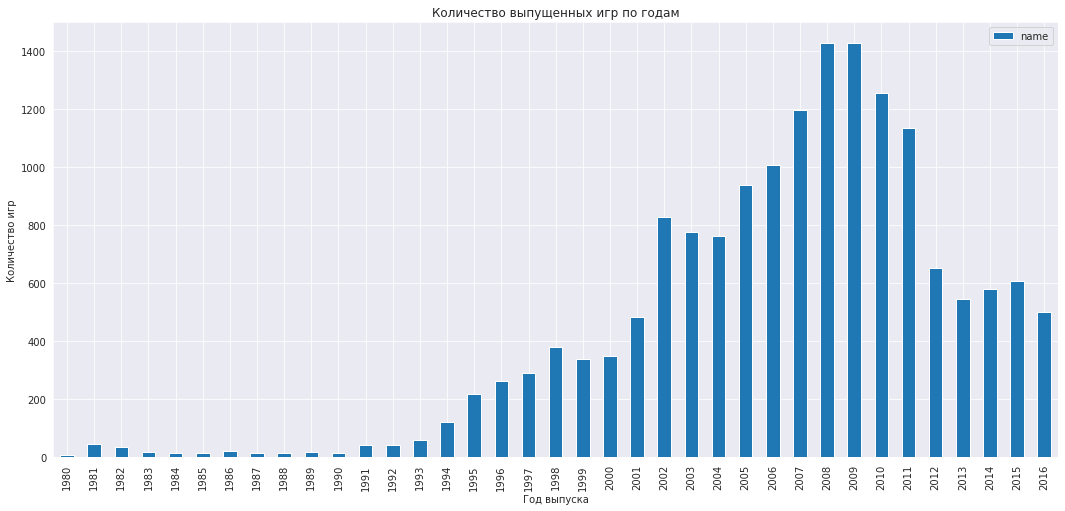

In [23]:
sns.set_style('darkgrid') #зададим стиль для дальнейшего построения графиков
(data.pivot_table(index='year_of_release', values='name', aggfunc='count')
     .plot(kind='bar', grid=True, figsize=(18,8)))
plt.title('Количество выпущенных игр по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр');
#строим график по сводной таблице, сгруппированной по годам, 
#содержащей в себе количество выпущенных игр

На графике можем видеть как развивалась игровая сфера с 1980 года, повышение интереса разработчиков к выпуску все большего количества разных игр к 2008 году, а с 2009 снижение такого интереса. В нашем анализе не все данные будут необходимы, но посмотрим сначала на то, как менялись продажи по платформам за весь период.

Построим график, чтобы увидеть примерное время появление платформы, актуальна ли она до сих пор или какой промежуток времени была актуальна.

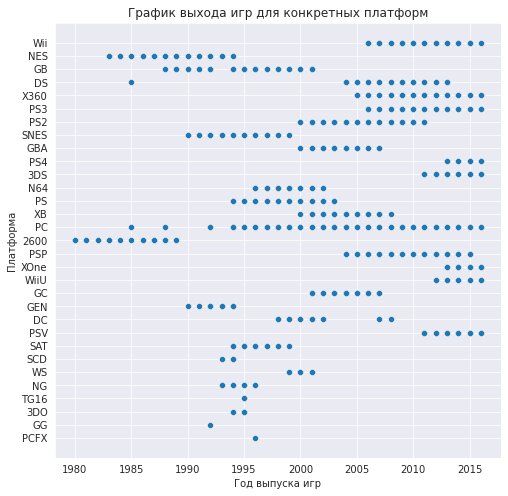

In [24]:
#выбираем оптимальный размер графика
fig = plt.figure(figsize=(8, 8)) 
#задаем данные для построения
sns.scatterplot(x='year_of_release', y='platform', data=data)
plt.title('График выхода игр для конкретных платформ')
plt.xlabel('Год выпуска игр')
plt.ylabel('Платформа');

Также вычислим среднюю продолжительность жизни платформы, это позволит нам прогнозировать срок жизни новых платформ.

In [25]:
#сводная таблица с годом начала продаж игр для платформы и завершением, либо текущий 2016 год
svod_platform = data.pivot_table(index='platform', values='year_of_release', aggfunc=['min','max']) 
#переименуем колонки
svod_platform.columns = ['birth', 'death'] 
#посмотрим сколько лет платформа жила/живет
svod_platform['term']=svod_platform['death']-svod_platform['birth'] 
print(svod_platform)
print()
#посмотрим на общую медиану
print(f'Медианная продолжительность жизни платформы: {svod_platform["term"].median()} лет') 

          birth  death  term
platform                    
2600       1980   1989     9
3DO        1994   1995     1
3DS        2011   2016     5
DC         1998   2008    10
DS         1985   2013    28
GB         1988   2001    13
GBA        2000   2007     7
GC         2001   2007     6
GEN        1990   1994     4
GG         1992   1992     0
N64        1996   2002     6
NES        1983   1994    11
NG         1993   1996     3
PC         1985   2016    31
PCFX       1996   1996     0
PS         1994   2003     9
PS2        2000   2011    11
PS3        2006   2016    10
PS4        2013   2016     3
PSP        2004   2015    11
PSV        2011   2016     5
SAT        1994   1999     5
SCD        1993   1994     1
SNES       1990   1999     9
TG16       1995   1995     0
WS         1999   2001     2
Wii        2006   2016    10
WiiU       2012   2016     4
X360       2005   2016    11
XB         2000   2008     8
XOne       2013   2016     3

Медианная продолжительность жизни платформ

Можно сделать выводы как для средней платформы (медианная продолжительность ее жизни составит 6 лет), так и по конкретным брендам. Например, средняя продолжительность жизни PlayStation примерно 10 лет. А значит PS4 скорее всего только подходит к середине своего жизненного цикла. Похожие выводы можно сделать о платформе XOne на основании статистики по их предшественникам.

Найдем платформы с наибольшими суммарными продажами и построим гистограмму.

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
PC       255.76
GB       254.43
XB       251.57
NES      251.05
N64      218.01
SNES     200.04
GC       196.73
XOne     159.32
2600      86.48
WiiU      82.19
PSV       53.81
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: world_sales, dtype: float64


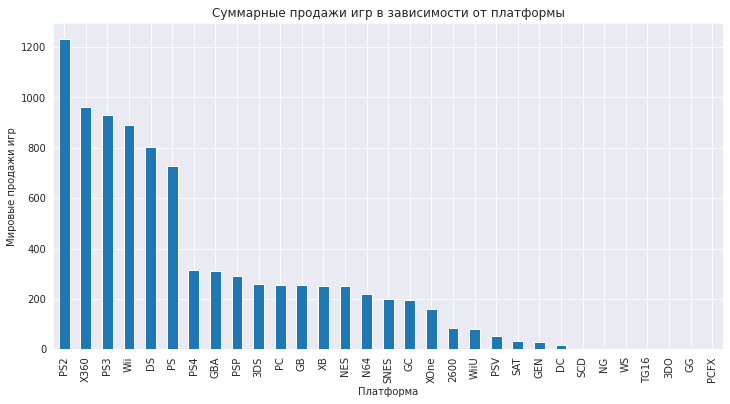

In [26]:
print(data.groupby('platform').sum('world_sales')
          .sort_values(by='world_sales', ascending = False)['world_sales'])
(data.groupby('platform')
     .sum('world_sales')
     .sort_values(by='world_sales', ascending = False)['world_sales']
     .plot(kind='bar', figsize=(12,6)))
plt.title('Суммарные продажи игр в зависимости от платформы')
plt.xlabel('Платформа')
plt.ylabel('Мировые продажи игр');

И построим для них распределение по годам.

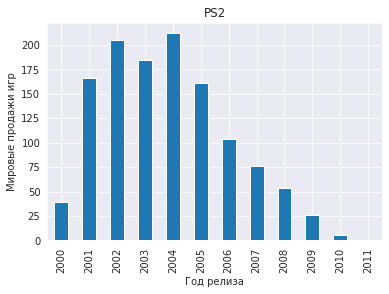

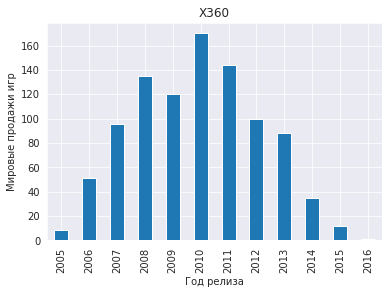

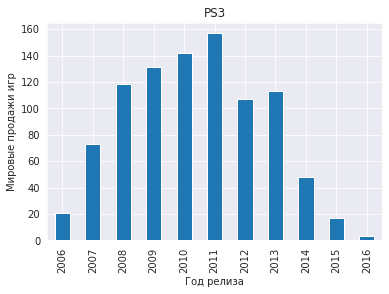

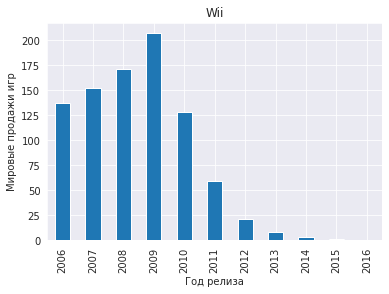

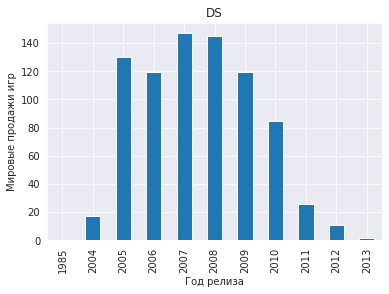

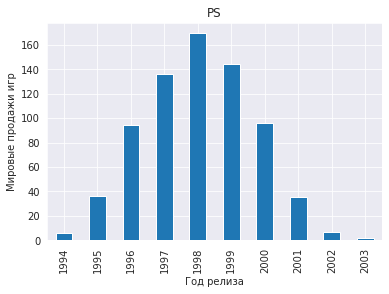

In [27]:
for x in ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']: #циклом ищем в базе наиболее популярные платформы
    data[data['platform']==x].groupby('year_of_release')['world_sales'].sum().plot(kind='bar', grid=True)
    #и строим для каждой график с суммарным кол-вом мировых продаж по годам
    plt.title(x) #заголовки платформ
    plt.xlabel('Год релиза')
    plt.ylabel('Мировые продажи игр')
    plt.show()

Для дальнейшего анализа оставим данные только за актуальный период - 3 года. Такой срок будет являться оптимальным для построения прогноза на 2017 год.

In [28]:
data = data[data['year_of_release']>2013].reset_index() #отсекаем игры выпущенные до 2014 года

Теперь проверим какие платформы лидируют по продажам в определенный нами актуальный период.

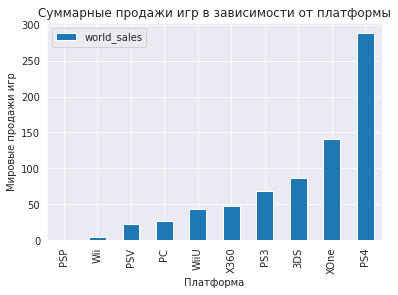

In [29]:
(data.pivot_table(index='platform', values='world_sales', aggfunc='sum')
     .sort_values(by='world_sales').plot(kind='bar', grid=True))
plt.title('Суммарные продажи игр в зависимости от платформы')
plt.xlabel('Платформа')
plt.ylabel('Мировые продажи игр');

Как и предполагалось, в последние годы на пике популярности платформы нового поколения, постепенно заменившие собой своих предшественников внутри бренда. Лидер продаж - PS4, затем идут XOne, 3DS и остальные.

Теперь проследим тенденции последних трех лет внутри представленных платформ.

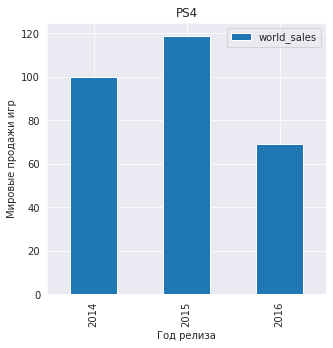

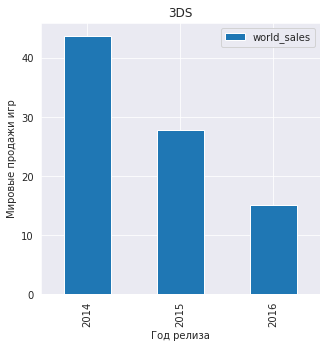

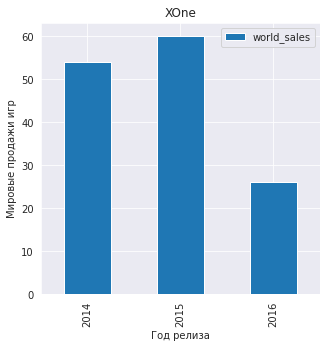

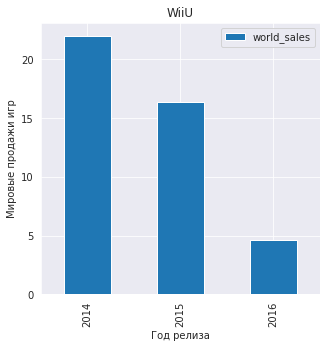

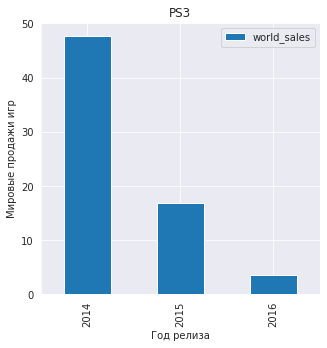

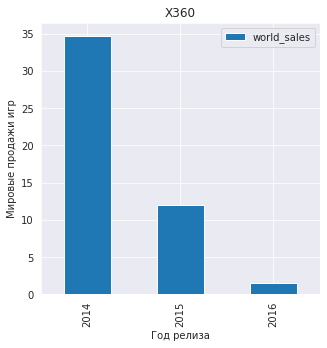

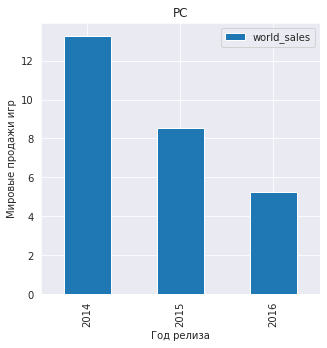

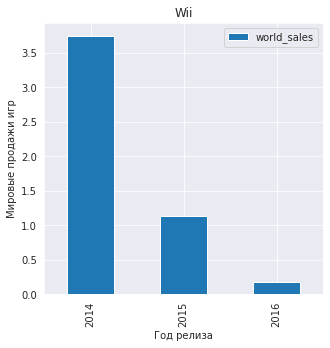

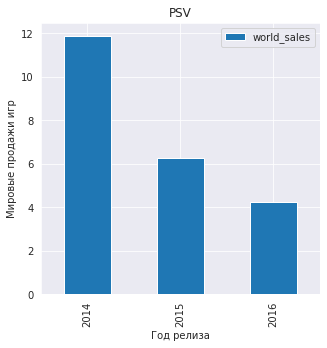

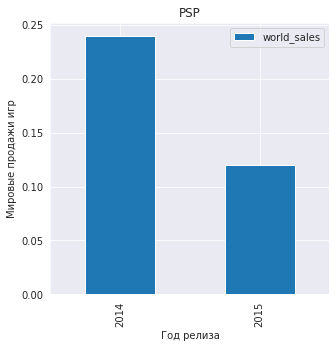

In [30]:
#для каждой платформы в отельности строим график по аналогии с общим
for x in data['platform'].unique(): 
    (data[data['platform']==x]
         .pivot_table(index='year_of_release', values='world_sales', aggfunc='sum')
         .plot(kind='bar', grid=True, figsize=(5,5)))
    plt.title(x)
    plt.xlabel('Год релиза')
    plt.ylabel('Мировые продажи игр')
    plt.show()

- К потенциально прибыльным платформам отнесем PS4, так как она несомненно является самой популярной на текущий момент. 
- XOne также довольно популярна и не сильно просела в продаваемости игр по сравнению с другими платформами.
- В тройку лидеров также можно включить 3DS, но неплохо было бы далее более детально изучить природу ее популярности.

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

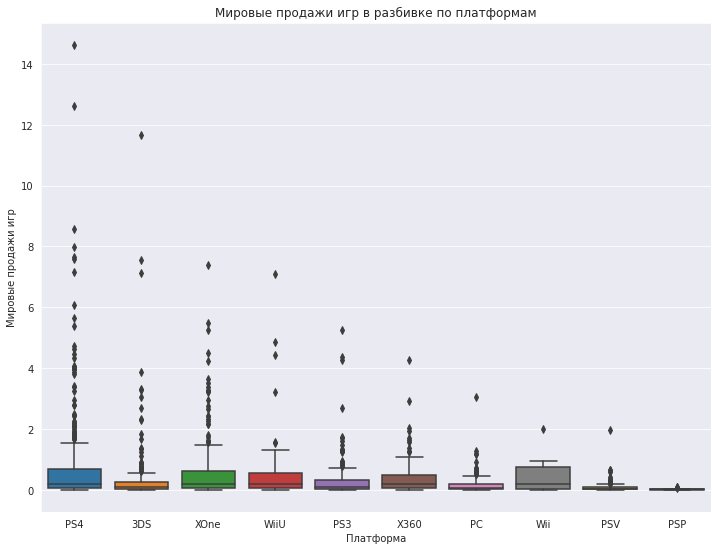

In [31]:
plt.figure(figsize=(12,9))
sns.boxplot(data=data, y='world_sales', x='platform')
plt.title('Мировые продажи игр в разбивке по платформам')
plt.xlabel('Платформа')
plt.ylabel('Мировые продажи игр')
plt.show()

Можем наблюдать на графике точки-выбросы, которые показывают абсолютных лидеров продаж по платформам - игры-бестселлеры.

Теперь приглядимся к самим "ящикам".

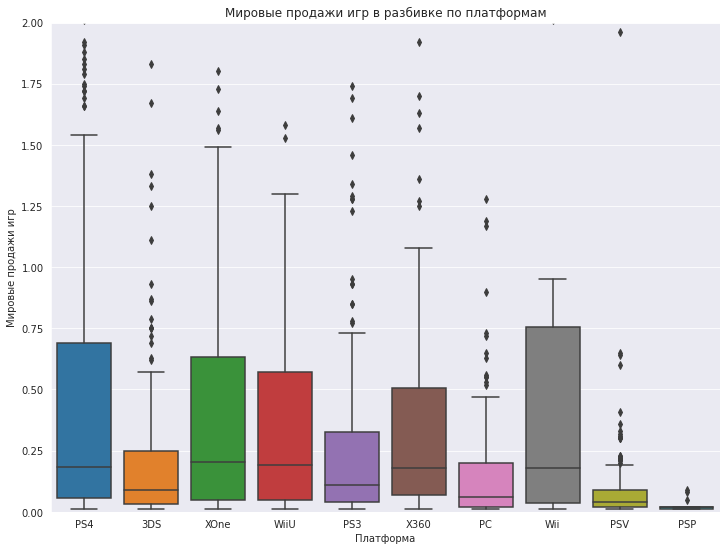

In [32]:
plt.figure(figsize=(12,9))
sns.boxplot(data=data, y='world_sales', x='platform').set(ylim=(0,2))
plt.title('Мировые продажи игр в разбивке по платформам')
plt.xlabel('Платформа')
plt.ylabel('Мировые продажи игр')
plt.show()

У большинства платформ медиана примерно одинаковая - 0.2 млн проданных копий.

Изучим влияние отзывов пользователей и критиков на продажи внутри платформы PS4. 
Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

-0.040131589472697356

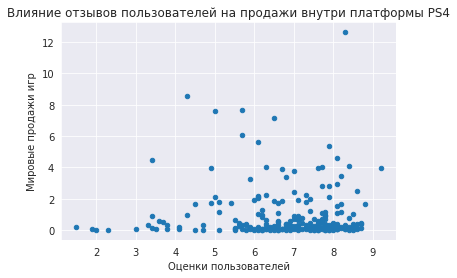

In [33]:
(data.query('platform == "PS4" & user_score!=-1')
     .plot(x='user_score', y='world_sales', kind='scatter'))
plt.title('Влияние отзывов пользователей на продажи внутри платформы PS4')
plt.xlabel('Оценки пользователей')
plt.ylabel('Мировые продажи игр'); 
(data.query('platform == "PS4" & user_score!=-1')['user_score']
     .corr(data['world_sales']))
#берем срез по платформе и отсекаем значения-заглушки

Влияние отзывов пользователей на продажи внутри платформы PS4 не наблюдается, корреляция почти нулевая.

0.40266141068104083

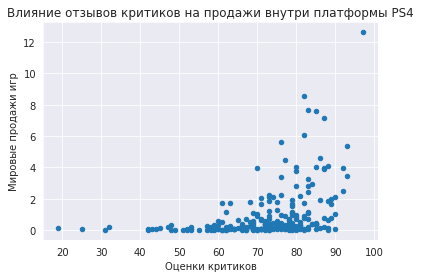

In [34]:
(data.query('platform == "PS4" & critic_score!=-1')
     .plot(x='critic_score', y='world_sales', kind='scatter'))
plt.title('Влияние отзывов критиков на продажи внутри платформы PS4')
plt.xlabel('Оценки критиков')
plt.ylabel('Мировые продажи игр');
(data.query('platform == "PS4" & critic_score!=-1')['critic_score']
     .corr(data['world_sales']))

А вот от оценки критиков есть прямая зависимость, но не явная.

Соотнесем выводы с продажами игр на других платформах, исключив влияние PS4 на те же показатели.

-0.023478187237975554

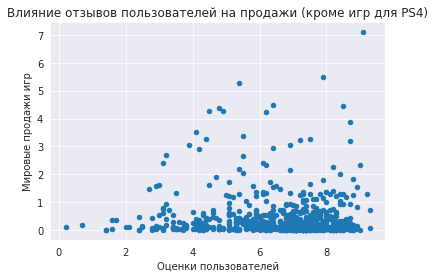

In [35]:
(data.query('platform != "PS4" & user_score!=-1')
     .plot(x='user_score', y='world_sales', kind='scatter'))
plt.title('Влияние отзывов пользователей на продажи (кроме игр для PS4)')
plt.xlabel('Оценки пользователей')
plt.ylabel('Мировые продажи игр');
(data.query('platform != "PS4" & user_score!=-1')['user_score']
     .corr(data['world_sales']))
#исключаем отдельно проверенную платформу и значения-заглушки

0.3094740026001152

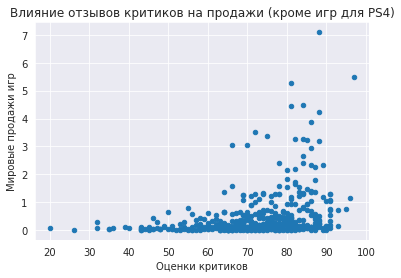

In [36]:
(data.query('platform != "PS4" & critic_score!=-1')
     .plot(x='critic_score', y='world_sales', kind='scatter'))
plt.title('Влияние отзывов критиков на продажи (кроме игр для PS4)')
plt.xlabel('Оценки критиков')
plt.ylabel('Мировые продажи игр');
(data.query('platform != "PS4" & critic_score!=-1')['critic_score']
     .corr(data['world_sales']))

На других платформах тенденция сохранилась.

Посмотрим на общее распределение игр по жанрам.

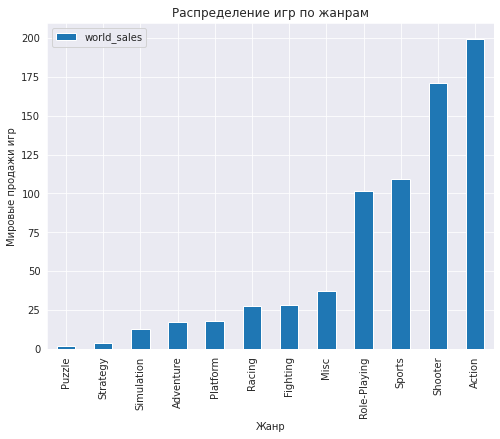

In [37]:
(data.pivot_table(index='genre', values='world_sales', aggfunc='sum')
     .sort_values(by='world_sales')
     .plot(kind='bar', figsize=(8,6)))
plt.title('Распределение игр по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Мировые продажи игр');

Жанры Action, Shooter, Sports, Role_Playing превосходят остальные жанры по общему числу продаж.

Построим график «ящик с усами», чтобы посмотреть как обстоят дела с медианными показателями и межквартильным размахом.

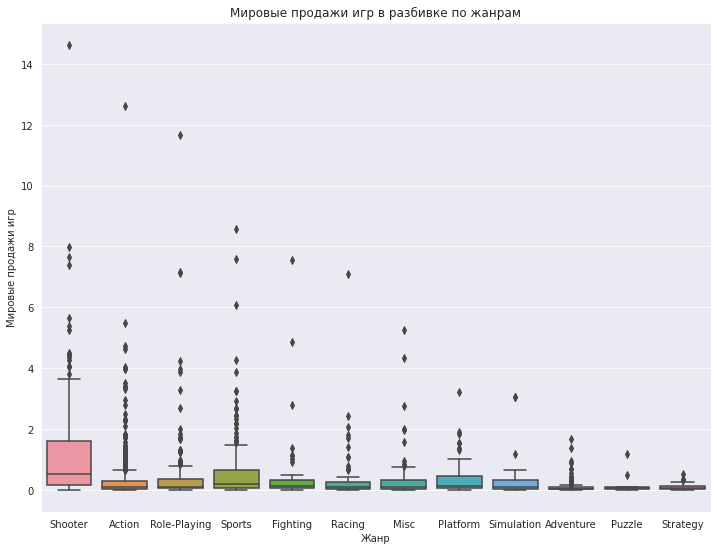

In [38]:
plt.figure(figsize=(12,9))
sns.boxplot(data=data, y='world_sales', x='genre')
plt.title('Мировые продажи игр в разбивке по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Мировые продажи игр')
plt.show()

Можем наблюдать на графике точки-выбросы, которые показывают абсолютных лидеров продаж по жанрам - игры-бестселлеры.

Зададим пределы графика и рассмотрим более детально основные показатели.

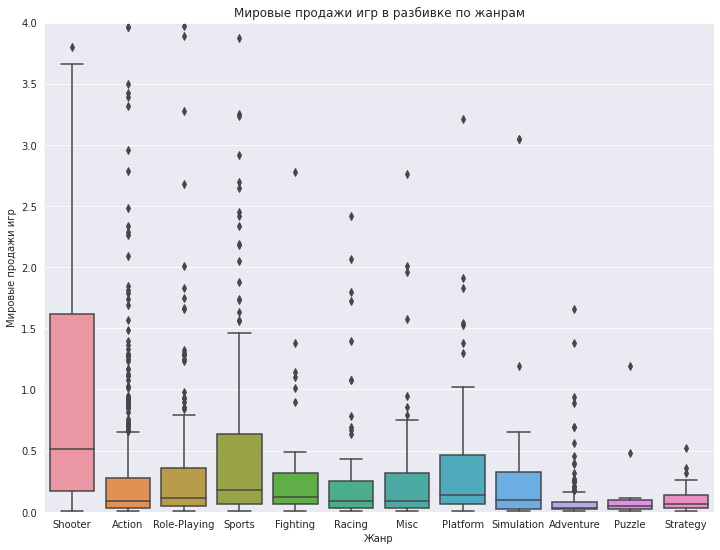

In [39]:
plt.figure(figsize=(12,9))
sns.boxplot(data=data, y='world_sales', x='genre').set(ylim=(0,4))
plt.title('Мировые продажи игр в разбивке по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Мировые продажи игр')
plt.show()

In [40]:
#проверим отношение числа выпущенных игр жанра Action к общему значаению выпущенных игр
data[data['genre']=='Action']['genre'].count() / data['genre'].count()

0.3664890467732386

Оказалось, что за высокими показателями общих продаж жанра Action стоит довольно скромное значение медианы и межквартильного размаха продаж по этому жанру.  То есть игр выпускается много (треть от общего числа), но чаще всего эти игры не сильно успешны. Зато жанр Shooter оправдал свои высокие продажи  показателями на диаграмме размаха, он стабильно приносит высокий доход. Медианное значение жанра Shooter превосходит любой другой жанр минимум в 2 раза.

## Портрет пользователя каждого региона

### Популярность платформ

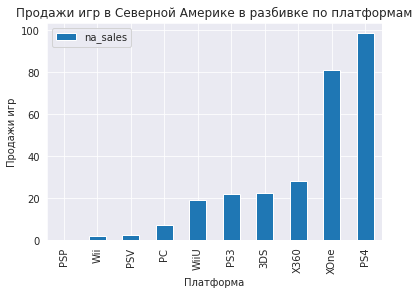

In [41]:
(data.pivot_table(index='platform', values='na_sales', aggfunc='sum')
     .sort_values('na_sales').plot(kind='bar'))
plt.title('Продажи игр в Северной Америке в разбивке по платформам')
plt.xlabel('Платформа')
plt.ylabel('Продажи игр');

В Северной Америке самыми популярными платформами являются PS4 и XOne. Значительно меньшей популярностью обладают X360, 3DS, PS3. WiiU не входит в топ-5 но почти не уступает его замыкающим.

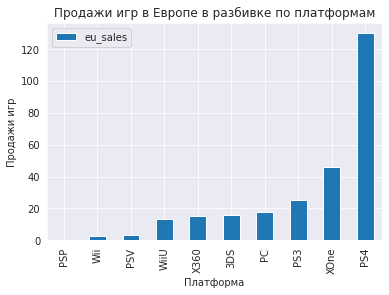

In [42]:
(data.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
     .sort_values('eu_sales').plot(kind='bar'))
plt.title('Продажи игр в Европе в разбивке по платформам')
plt.xlabel('Платформа')
plt.ylabel('Продажи игр');

В Европе платформа PS4 с большим отрывом занимает лидирующую позицию. Далее: XOne, PS3 и примерно на одном уровне PС, 3DS. В топ-5 не вошли X360 и WiiU, но справедливости ради могли бы разделить 5 место между собой.

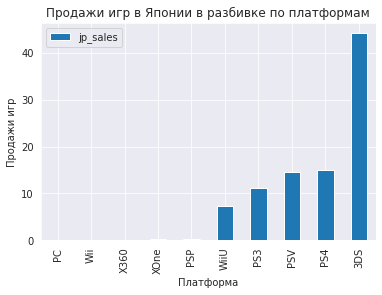

In [43]:
(data.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
     .sort_values('jp_sales').plot(kind='bar'))
plt.title('Продажи игр в Японии в разбивке по платформам')
plt.xlabel('Платформа')
plt.ylabel('Продажи игр');

Стало понятно почему в мировых продажах третье место уверенно заняла платформа 3DS - она невероятно популярна в Японии! Далее: PS4, PSV, PS3, WiiU.

### Популярность жанров

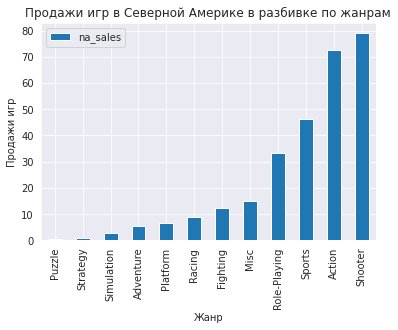

In [44]:
(data.pivot_table(index='genre', values='na_sales', aggfunc='sum')
     .sort_values('na_sales').plot(kind='bar'))
plt.title('Продажи игр в Северной Америке в разбивке по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Продажи игр');

В Северной Америке самыми популярным жанрами являются Action и Shooter. Менее популярны Sports и Role-Playing. Пятое место в рейтинге занимает Misc.

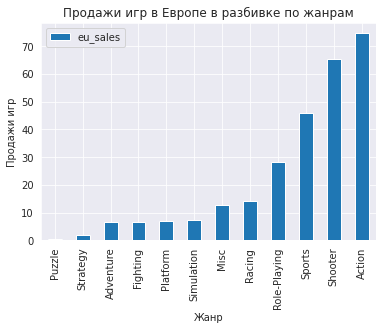

In [45]:
(data.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
     .sort_values('eu_sales').plot(kind='bar'))
plt.title('Продажи игр в Европе в разбивке по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Продажи игр');

В Европе также наиболее популярны Action и Shooter, но отличие есть: Action в данном регионе популярнее, чем Shooter. Sports и Role-Playing аналогично занимают в рейтинге 3 и 4 места, но 5е место здесь занимает жанр Racing.

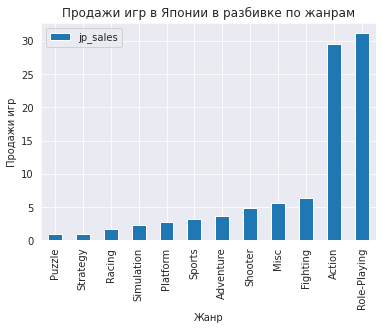

In [46]:
(data.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
     .sort_values('jp_sales').plot(kind='bar'))
plt.title('Продажи игр в Японии в разбивке по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Продажи игр');

В Японии первое место по продажам занимает жанр Role-Playing, и также не менее популярен Action. Значительно менее популярны и занимают 3, 4 и 5 места жанры: Fighting, Misc, Shooter.

### Влияние рейтинга ESRB на продажи в отдельном регионе

Построим графики распределения продаж игр в зависимости от возрастного рейтинга по регионам.

- «E» («Everyone») — «Для всех»;
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»;
- «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет;
- «M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет.

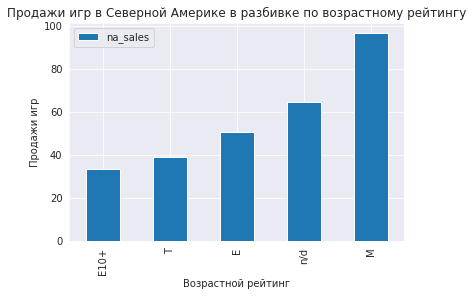

In [47]:
(data.pivot_table(index='rating', values='na_sales', aggfunc='sum')
     .sort_values('na_sales').plot(kind='bar'))
plt.title('Продажи игр в Северной Америке в разбивке по возрастному рейтингу')
plt.xlabel('Возрастной рейтинг')
plt.ylabel('Продажи игр');

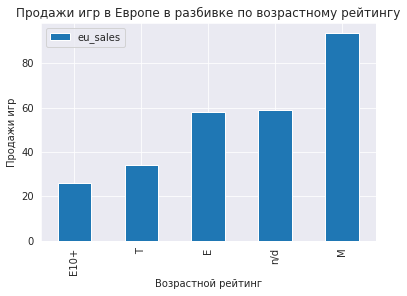

In [48]:
(data.pivot_table(index='rating', values='eu_sales', aggfunc='sum')
     .sort_values('eu_sales').plot(kind='bar'))
plt.title('Продажи игр в Европе в разбивке по возрастному рейтингу')
plt.xlabel('Возрастной рейтинг')
plt.ylabel('Продажи игр');

В Северной Америке и Европе набильшей популярностью пользуются игры с рейтингом M.

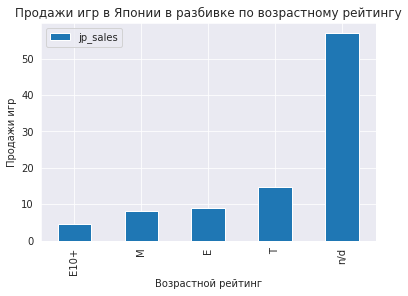

In [49]:
(data.pivot_table(index='rating', values='jp_sales', aggfunc='sum')
     .sort_values('jp_sales').plot(kind='bar'))
plt.title('Продажи игр в Японии в разбивке по возрастному рейтингу')
plt.xlabel('Возрастной рейтинг')
plt.ylabel('Продажи игр');

Тогда как в Японии дела обстоят по-другому. Здесь первое место по продажам занимают игры с неопределенным рейтингом. Дело в том, что ESRB – это рейтинг США и игры выпущенные в Японии для локального рынка его не проходят.

## Проверка гипотез

### Гипотеза №1

- Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
- Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC разные.

In [50]:
#sample_1 - выборка из первой генеральной совокупности
sample_1 = data.query('platform=="XOne" & user_score!=0')['user_score'] 
#sample_2 - выборка из второй генеральной совокупности
sample_2 = data.query('platform=="PC" & user_score!=0')['user_score'] 
alpha = .05 #задаем пороговое значение
results = st.ttest_ind(sample_1, sample_2, equal_var=False)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
print('p-значение: ', results.pvalue)

Не получилось отвергнуть нулевую гипотезу
p-значение:  0.26246011727057744


Вывод означает, что мы не смогли опровергнуть утверждение, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Так что скорее всего их средние значения действительно примерно равны.

### Гипотеза №2

- Нулевая гипотеза: средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.
- Альтернативная гипотеза: средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [51]:
#sample_1 - выборка из первой генеральной совокупности
sample_1 = data.query('genre=="Action" & user_score!=0')['user_score'] 
#sample_2 - выборка из второй генеральной совокупности
sample_2 = data.query('genre=="Sports" & user_score!=0')['user_score'] 
alpha = .05 #задаем пороговое значение
results = st.ttest_ind(sample_1, sample_2, equal_var=False)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
print('p-значение: ', results.pvalue)

Отвергаем нулевую гипотезу
p-значение:  4.829371809684136e-05


Вывод означает, что мы не можем утверждать, что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.

## Общий вывод

Все представленные общие выводы будут основаны на данных за последние 3 года, так как этот период выбран как оптимальный для нашего исследования.

### Платформы

Еще раз взглянем на лидеров продаж по платформам.

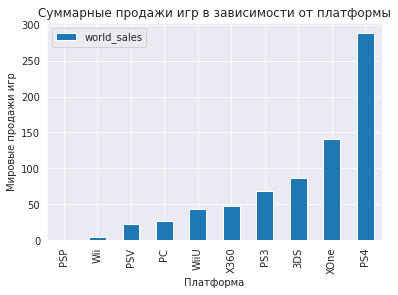

In [52]:
(data.pivot_table(index='platform', values='world_sales', aggfunc='sum')
     .sort_values(by='world_sales').plot(kind='bar', grid=True))
plt.title('Суммарные продажи игр в зависимости от платформы')
plt.xlabel('Платформа')
plt.ylabel('Мировые продажи игр');

В последние годы на пике популярности платформы нового поколения, постепенно заменившие собой своих предшественников внутри бренда. Лидер продаж - PS4, на втором месте XOne. Эти платформы популярны в Северной Америке и Европе. 

3DS расположилась на третьем месте - это невероятно популярная в Японии платформа:

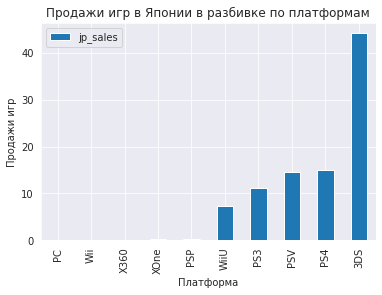

In [53]:
(data.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
     .sort_values('jp_sales').plot(kind='bar'))
plt.title('Продажи игр в Японии в разбивке по платформам')
plt.xlabel('Платформа')
plt.ylabel('Продажи игр');

### Жанры

Shooter - наиболее успешный в мире жанр. Далее идут Sports и Platform. 
Игр жанра Action выпускается огромное количество (треть об общего числа), но значительная их часть не является успешной, хоть и большое количество выбросов соответственно говорит о большом количестве игр-бестселлеров в этом жанре.

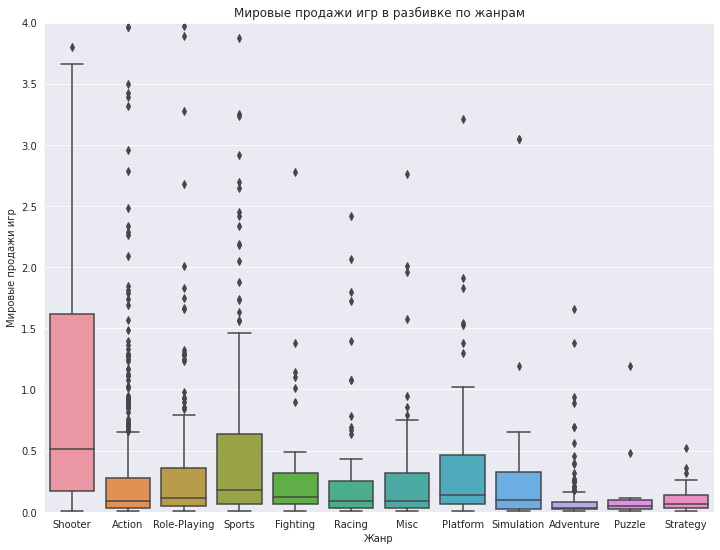

In [54]:
plt.figure(figsize=(12,9))
sns.boxplot(data=data, y='world_sales', x='genre').set(ylim=(0,4))
plt.title('Мировые продажи игр в разбивке по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Мировые продажи игр')
plt.show()

Картина, описанная выше, подходит под американского или европейского потребителя. Но если мы будем ориентироваться на Японию, самым продаваемым жанром здесь окажется Role-Playing:

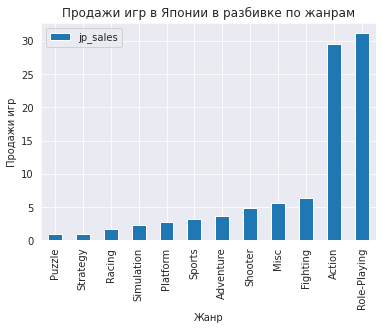

In [55]:
(data.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
     .sort_values('jp_sales').plot(kind='bar'))
plt.title('Продажи игр в Японии в разбивке по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Продажи игр');

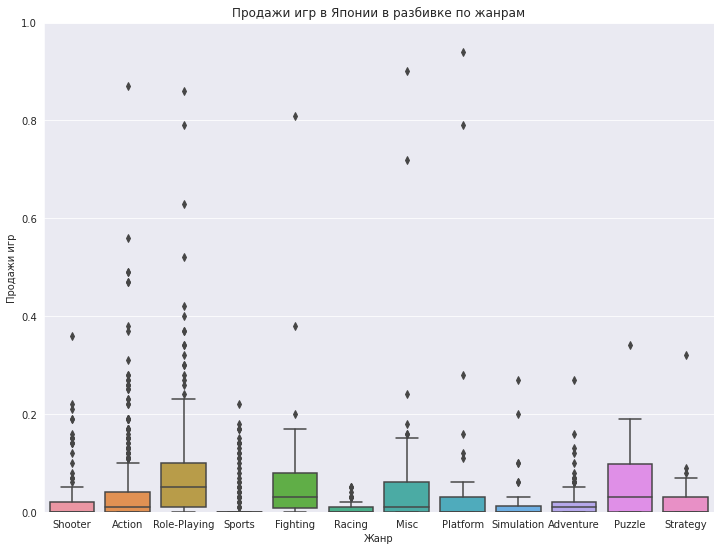

In [56]:
plt.figure(figsize=(12,9))
sns.boxplot(data=data, y='jp_sales', x='genre').set(ylim=(0,1))
plt.title('Продажи игр в Японии в разбивке по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Продажи игр')
plt.show()

### Возрастной рейтинг

В Северной Америке и Европе наиболее популярны игры с рейтингом М:

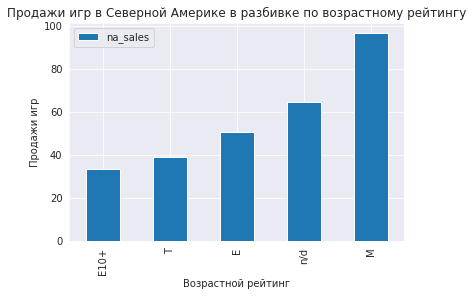

In [57]:
(data.pivot_table(index='rating', values='na_sales', aggfunc='sum')
     .sort_values('na_sales').plot(kind='bar'))
plt.title('Продажи игр в Северной Америке в разбивке по возрастному рейтингу')
plt.xlabel('Возрастной рейтинг')
plt.ylabel('Продажи игр');

Тогда как в Японии дела обстоят по-другому. Здесь первое место по продажам занимают игры с неопределенным рейтингом. Дело в том, что ESRB – это рейтинг США и игры выпущенные в Японии для локального рынка его не проходят.

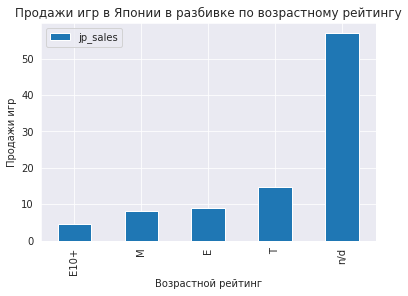

In [58]:
(data.pivot_table(index='rating', values='jp_sales', aggfunc='sum')
     .sort_values('jp_sales').plot(kind='bar'))
plt.title('Продажи игр в Японии в разбивке по возрастному рейтингу')
plt.xlabel('Возрастной рейтинг')
plt.ylabel('Продажи игр');

### Кратко о выдвинутых гипотезах

- Мы не можем утверждать, что средние пользовательские рейтинги платформ Xbox One и PC отличаются друг от друга;
- Мы не можем утверждать, что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.